In [7]:
import h5py
import copy
import lmfit
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from rich.progress import Progress
from scipy.stats import binned_statistic
from utils.plot_utils import set_fontsize
from utils.hdf_utils import load_measurement_data_devices_attrs

In [8]:
def ratio_with_error(a,b,σa,σb):
    ratio = a/b
    err = ratio * np.sqrt((σa/a)**2 + (σb/b)**2)
    return ratio, err

In [9]:
hdf_dir = Path("../data")

In [10]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3
shutter_channel = 4
pdrc_channel = 5

In [11]:
fname = "2021_3_29.hdf"

with h5py.File(hdf_dir / fname, 'r') as f:
    dset_names = list(f.keys())
    for idn, name in enumerate(f.keys()):
        print(f"{idn:<2} <> {name:<80} : {len(f[name]['readout']['PXIe-5171'])}")

0  <> 1617047332 scan Q23 (Q23 DET P2 F1 RC J12 J23 microwaves)                        : 491
1  <> 1617047771 scan Q23 (Q23 DET P2 F1 RC J12 J23 microwaves)                        : 641
2  <> 1617048216 scan P2 F1 (Q23 DET P2 F1 RC J12 J23 microwaves)                      : 961
3  <> 1617049288 scan laser pol freq only (Q23 DET P2 F1 RC J12 J23 microwaves)        : 10001
4  <> 1617052227 no laser pol switching (Q23 DET P2 F1 RC J12 J23 microwaves)          : 2001
5  <> 1617053821 removed conoptics EOM from RC (Q23 DET P2 F1 RC J12 J23 microwaves)   : 2001
6  <> 1617054357 scan pol switching frequency microwaves (Q23 DET P2 F1 RC J12 J23 microwaves) : 102
7  <> 1617054429 scan pol switching frequency microwaves (Q23 DET P2 F1 RC J12 J23 microwaves) : 10001
8  <> 1617056410 scan J12 powers (Q23 DET P2 F1 RC J12 J23 microwaves)                 : 15001
9  <> 1617058923 scan J23 powers (Q23 DET P2 F1 RC J12 J23 microwaves)                 : 12001


## Scan Switching Frequency Laser Only with Q23 DET

In [12]:
slice_flm  = np.s_[-500:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [13]:
dnames = [dset_names[3]]
devices = ()

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
                     
for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

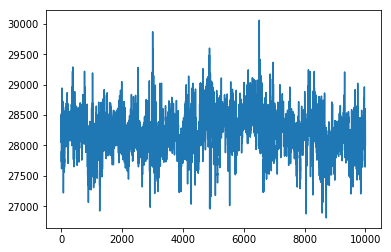

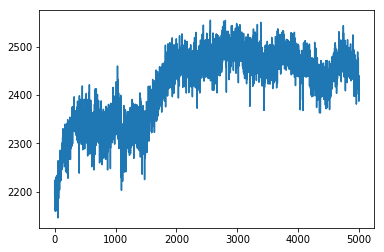

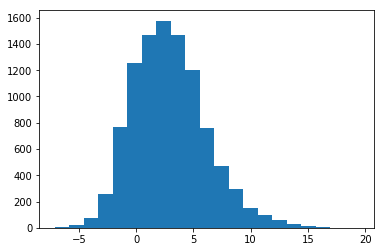

In [14]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), bins = 21);

In [15]:
yag_cutoff = 250
ptn_cutoff = 12000
abs_cutoff = 3
fl_cutoff = -5000

In [16]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

54.7% data discarded


In [17]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

n = fluorescence_integral/absorption_integral

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

In [18]:
ngroup = 500

In [19]:
o = fluorescence_integral[mask_sh_open].reshape(-1,ngroup//2)/\
    absorption_integral[mask_sh_open].reshape(-1,ngroup//2)
c = fluorescence_integral[mask_sh_closed].reshape(-1, ngroup//2)/\
    absorption_integral[mask_sh_closed].reshape(-1, ngroup//2)

In [20]:
ratio, err = ratio_with_error(np.nanmean(o, axis = 1), np.nanmean(c, axis = 1), 
                              np.nanstd(o, axis = 1)/np.sqrt(np.sum(~np.isnan(o), axis = 1)),
                              np.nanstd(c, axis = 1)/np.sqrt(np.sum(~np.isnan(c), axis = 1))
                             )

In [21]:
ratio = ratio.reshape(-1,5)
err = err.reshape(-1,5)

In [22]:
frequencies = np.array([0.5, 1, 1.25, 1.5, 2])*1e6

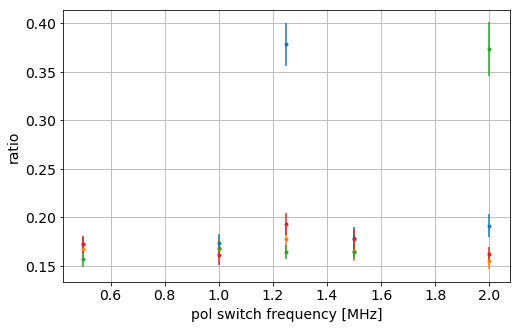

In [23]:
fig, ax = plt.subplots(figsize = (8,5))
for r, e in zip(ratio, err):
    ax.errorbar(frequencies/1e6, r, yerr = e, fmt = '.')

ax.set_xlabel('pol switch frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

points where ratio is suddenly $\approx 0.4$ had the polarization switching suddenly turn off. Seems to happen sometimes when the laser pol switching frequency is changed, need to investigage further.

In [24]:
# remove points where the RC laser was acting up
m = (pdrc_data.min(axis = 1)[mask_sh_open].reshape(-1, ngroup//2).min(axis = 1)) < 1000
m = m.reshape(-1,5)
ratio[m] = np.nan
err[m] = np.nan

# remove points far outside the mean
std_factor = 4
rmean = np.nanmedian(ratio, axis = 0)
rstd = np.nanmedian(err, axis = 0)

m = ~((ratio >= rmean - std_factor*rstd) & (ratio <= rmean + std_factor*rstd))
ratio[m] = np.nan
err[m] = np.nan

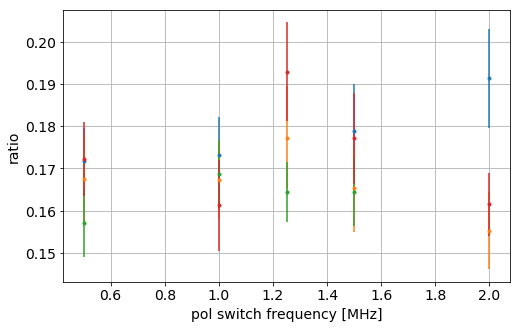

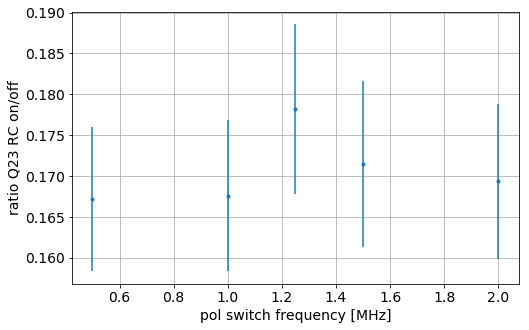

In [25]:
fig, ax = plt.subplots(figsize = (8,5))
for r, e in zip(ratio, err):
    ax.errorbar(frequencies/1e6, r, yerr = e, fmt = '.')

ax.set_xlabel('pol switch frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(frequencies/1e6, np.nanmean(ratio, axis=0), yerr = np.nanmean(err, axis=0), fmt = '.')

ax.set_xlabel('pol switch frequency [MHz]')
ax.set_ylabel('ratio Q23 RC on/off')

ax.grid(True)

set_fontsize(ax, 14)

In [26]:
res_copy = [frequencies, (ratio, err)]

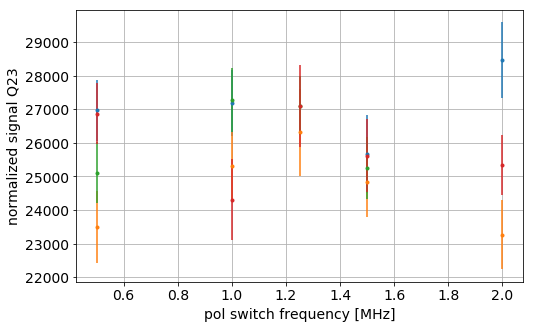

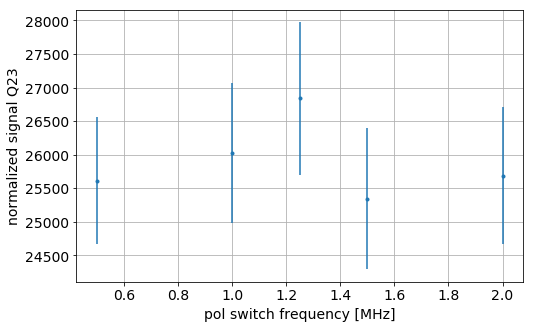

In [27]:
y = np.nanmean(o, axis = 1).reshape(-1,5)
y[m] = np.nan
yerr = np.nanstd(o, axis = 1)/np.sqrt((~np.isnan(o)).sum(axis = 1))
yerr = yerr.reshape(-1,5)
yerr[m] = np.nan

fig, ax = plt.subplots(figsize = (8,5))

for oi, oei in zip(y, yerr):
    ax.errorbar(frequencies/1e6, oi, yerr = oei, fmt = '.')
    

ax.set_xlabel('pol switch frequency [MHz]')
ax.set_ylabel('normalized signal Q23')

ax.grid(True)
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))

ax.errorbar(frequencies/1e6, np.nanmean(y, axis = 0), yerr = np.nanmean(yerr, axis = 0), fmt = '.')
    

ax.set_xlabel('pol switch frequency [MHz]')
ax.set_ylabel('normalized signal Q23')

ax.grid(True)
set_fontsize(ax, 14)

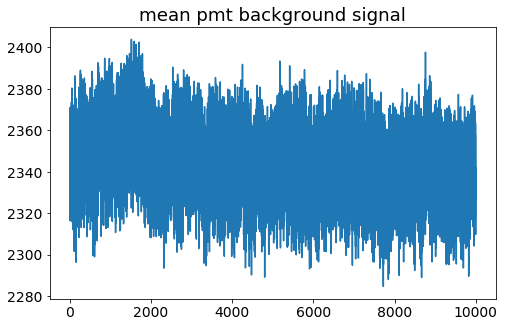

In [28]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pmt_data[:,-500:].mean(axis = 1))
ax.set_title('mean pmt background signal')
set_fontsize(ax, 14)

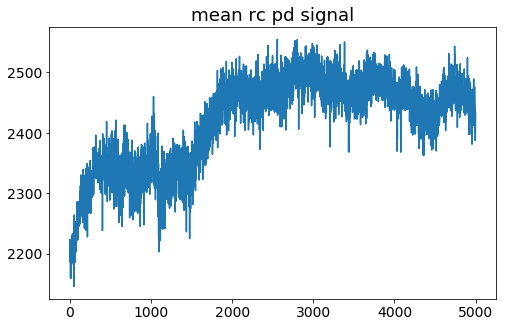

In [29]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdrc_data.mean(axis = 1)[mask_sh_open])
ax.set_title('mean rc pd signal')
set_fontsize(ax, 14)

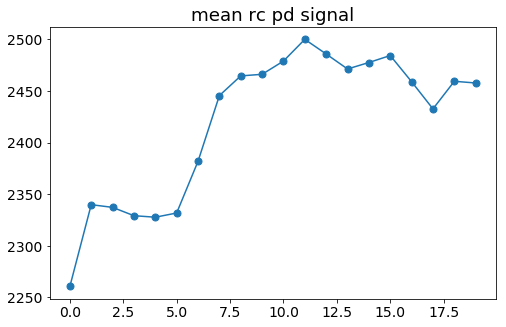

In [30]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdrc_data.mean(axis = 1)[mask_sh_open].reshape(-1, ngroup//2).mean(axis = 1), '.-', ms = 14)
ax.set_title('mean rc pd signal')
set_fontsize(ax, 14)

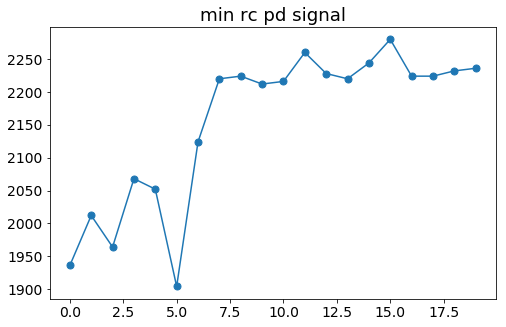

In [31]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdrc_data.min(axis = 1)[mask_sh_open].reshape(-1, ngroup//2).min(axis = 1), '.-', ms = 14)
ax.set_title('min rc pd signal')
set_fontsize(ax, 14)

## No Laser polarization switching Q23 DET

In [32]:
slice_flm  = np.s_[-500:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [33]:
dnames = [dset_names[4]]
devices = ()

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
                     
for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

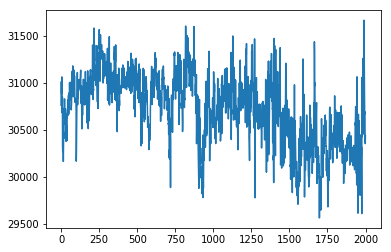

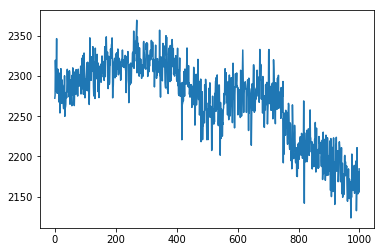

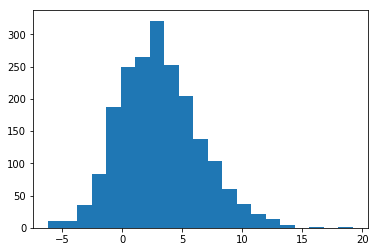

In [34]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), bins = 21);

In [35]:
yag_cutoff = 250
ptn_cutoff = 12000
abs_cutoff = 3
fl_cutoff = -5000

In [36]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

52.1% data discarded


In [37]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

n = fluorescence_integral/absorption_integral

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

In [38]:
ngroup = 500
nreshape = 1

In [39]:
o = fluorescence_integral[mask_sh_open].reshape(-1,ngroup//2)/\
    absorption_integral[mask_sh_open].reshape(-1,ngroup//2)
c = fluorescence_integral[mask_sh_closed].reshape(-1, ngroup//2)/\
    absorption_integral[mask_sh_closed].reshape(-1, ngroup//2)

In [40]:
ratio, err = ratio_with_error(np.nanmean(o, axis = 1), np.nanmean(c, axis = 1), 
                              np.nanstd(o, axis = 1)/np.sqrt(np.sum(~np.isnan(o), axis = 1)),
                              np.nanstd(c, axis = 1)/np.sqrt(np.sum(~np.isnan(c), axis = 1))
                             )

In [41]:
ratio = ratio.reshape(-1,nreshape)
err = err.reshape(-1,nreshape)

In [42]:
frequencies = np.array([0])*1e6

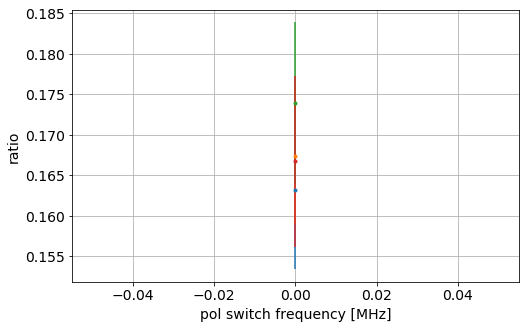

In [43]:
fig, ax = plt.subplots(figsize = (8,5))
for r, e in zip(ratio, err):
    ax.errorbar(frequencies/1e6, r, yerr = e, fmt = '.')

ax.set_xlabel('pol switch frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [44]:
# remove points where the RC laser was acting up
m = (pdrc_data.min(axis = 1)[mask_sh_open].reshape(-1, ngroup//2).min(axis = 1)) < 1000
m = m.reshape(-1,nreshape)
ratio[m] = np.nan
err[m] = np.nan

# remove points far outside the mean
std_factor = 4
rmean = np.nanmedian(ratio, axis = 0)
rstd = np.nanmedian(err, axis = 0)

m = ~((ratio >= rmean - std_factor*rstd) & (ratio <= rmean + std_factor*rstd))
ratio[m] = np.nan
err[m] = np.nan

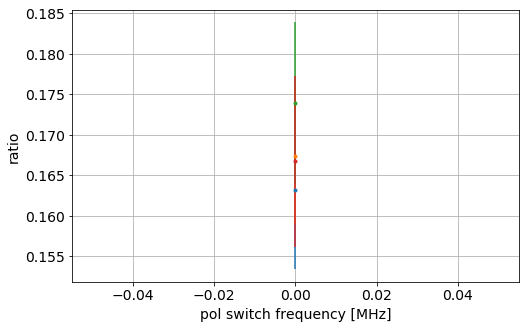

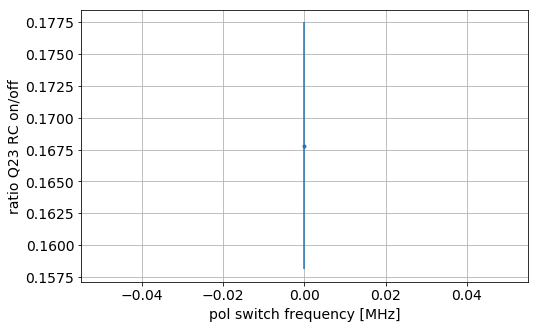

In [45]:
fig, ax = plt.subplots(figsize = (8,5))
for r, e in zip(ratio, err):
    ax.errorbar(frequencies/1e6, r, yerr = e, fmt = '.')

ax.set_xlabel('pol switch frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(frequencies/1e6, np.nanmean(ratio, axis=0), yerr = np.nanmean(err, axis=0), fmt = '.')

ax.set_xlabel('pol switch frequency [MHz]')
ax.set_ylabel('ratio Q23 RC on/off')

ax.grid(True)

set_fontsize(ax, 14)

Combine this datapoint with previous frequency scan

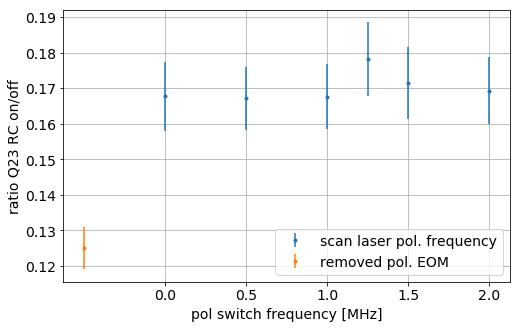

In [46]:
f = list(frequencies)
f.extend(list(res_copy[0]))
f = np.asarray(f)
r = list(np.nanmean(ratio, axis = 0))
r.extend(list(np.nanmean(res_copy[1][0], axis = 0)))
e = list(np.nanmean(err, axis = 0))
e.extend(list(np.nanmean(res_copy[1][1], axis = 0)))

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(f/1e6, r, yerr = e, fmt = '.', label = 'scan laser pol. frequency')
ax.errorbar(-0.5, 0.125, yerr = 0.006, fmt = '.', label = 'removed pol. EOM')
ax.set_xticks([0, 0.5, 1, 1.5, 2])
ax.legend(fontsize = 14, loc = 4)
ax.set_xlabel('pol switch frequency [MHz]')
ax.set_ylabel('ratio Q23 RC on/off')

ax.grid(True)

set_fontsize(ax, 14)

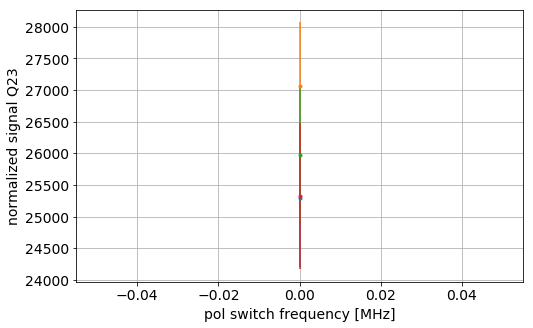

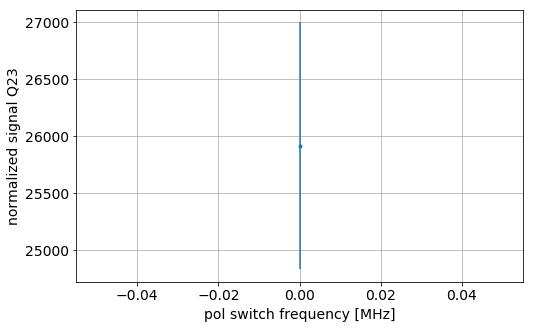

In [47]:
y = np.nanmean(o, axis = 1).reshape(-1,nreshape)
y[m] = np.nan
yerr = np.nanstd(o, axis = 1)/np.sqrt((~np.isnan(o)).sum(axis = 1))
yerr = yerr.reshape(-1,nreshape)
yerr[m] = np.nan

fig, ax = plt.subplots(figsize = (8,5))

for oi, oei in zip(y, yerr):
    ax.errorbar(frequencies/1e6, oi, yerr = oei, fmt = '.')
    

ax.set_xlabel('pol switch frequency [MHz]')
ax.set_ylabel('normalized signal Q23')

ax.grid(True)
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))

ax.errorbar(frequencies/1e6, np.nanmean(y, axis = 0), yerr = np.nanmean(yerr, axis = 0), fmt = '.')
    

ax.set_xlabel('pol switch frequency [MHz]')
ax.set_ylabel('normalized signal Q23')

ax.grid(True)
set_fontsize(ax, 14)

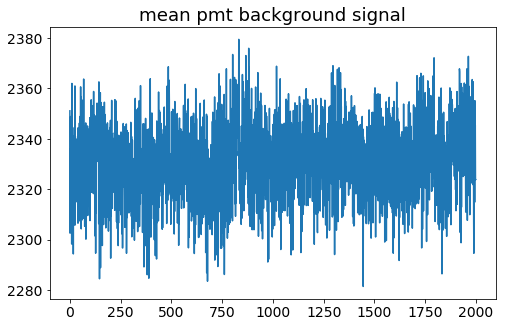

In [48]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pmt_data[:,-500:].mean(axis = 1))
ax.set_title('mean pmt background signal')
set_fontsize(ax, 14)

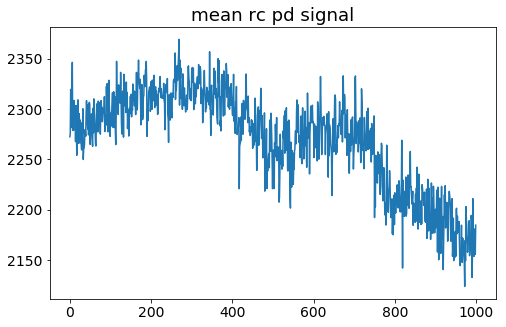

In [49]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdrc_data.mean(axis = 1)[mask_sh_open])
ax.set_title('mean rc pd signal')
set_fontsize(ax, 14)

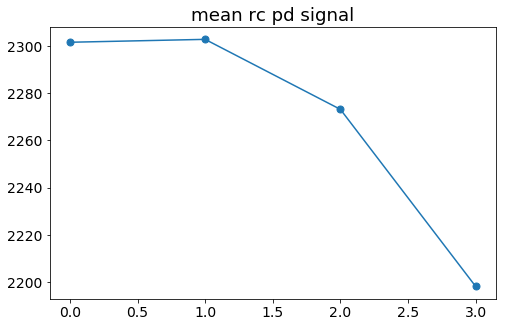

In [50]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdrc_data.mean(axis = 1)[mask_sh_open].reshape(-1, ngroup//2).mean(axis = 1), '.-', ms = 14)
ax.set_title('mean rc pd signal')
set_fontsize(ax, 14)

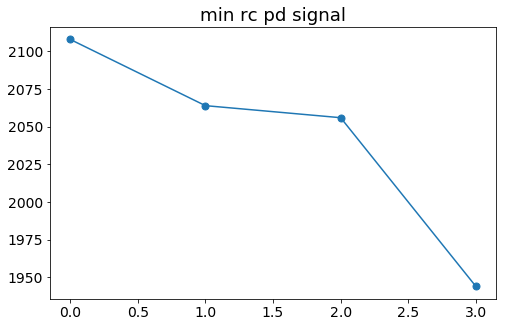

In [51]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdrc_data.min(axis = 1)[mask_sh_open].reshape(-1, ngroup//2).min(axis = 1), '.-', ms = 14)
ax.set_title('min rc pd signal')
set_fontsize(ax, 14)

## Removed pol switching RC laser Q23 DET
80 mW UV power

In [61]:
slice_flm  = np.s_[-500:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [65]:
dnames = [dset_names[5]]
devices = ()

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
                     
for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


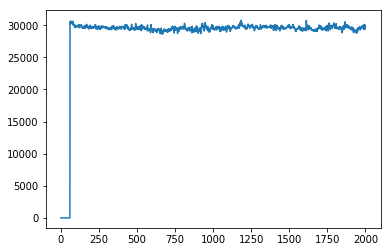

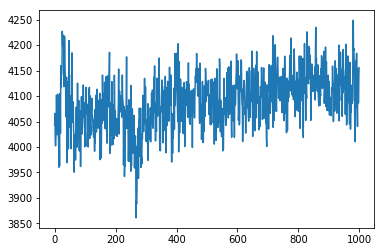

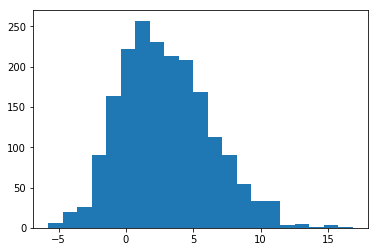

In [96]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_), bins = 21);

In [97]:
yag_cutoff = 250
ptn_cutoff = 12000
abs_cutoff = 3
fl_cutoff = -5000

In [98]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in subtract
  


55.8% data discarded


In [99]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

n = fluorescence_integral/absorption_integral

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

In [100]:
ngroup = 500
nreshape = 1

In [101]:
o = fluorescence_integral[mask_sh_open].reshape(-1,ngroup//2)/\
    absorption_integral[mask_sh_open].reshape(-1,ngroup//2)
c = fluorescence_integral[mask_sh_closed].reshape(-1, ngroup//2)/\
    absorption_integral[mask_sh_closed].reshape(-1, ngroup//2)

In [102]:
ratio, err = ratio_with_error(np.nanmean(o, axis = 1), np.nanmean(c, axis = 1), 
                              np.nanstd(o, axis = 1)/np.sqrt(np.sum(~np.isnan(o), axis = 1)),
                              np.nanstd(c, axis = 1)/np.sqrt(np.sum(~np.isnan(c), axis = 1))
                             )

In [103]:
ratio = ratio.reshape(-1,nreshape)
err = err.reshape(-1,nreshape)

In [104]:
frequencies = np.array([0])*1e6

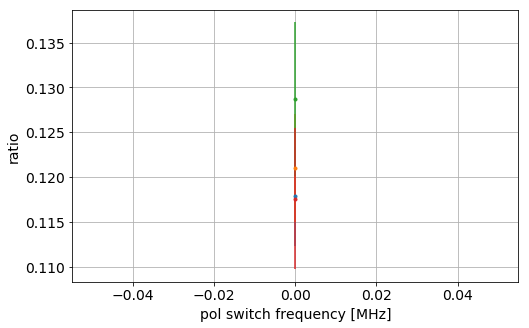

In [105]:
fig, ax = plt.subplots(figsize = (8,5))
for r, e in zip(ratio, err):
    ax.errorbar(frequencies/1e6, r, yerr = e, fmt = '.')

ax.set_xlabel('pol switch frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [106]:
# remove points where the RC laser was acting up
m = (pdrc_data.min(axis = 1)[mask_sh_open].reshape(-1, ngroup//2).min(axis = 1)) < 1000
m = m.reshape(-1,nreshape)
ratio[m] = np.nan
err[m] = np.nan

# remove points far outside the mean
std_factor = 4
rmean = np.nanmedian(ratio, axis = 0)
rstd = np.nanmedian(err, axis = 0)

m = ~((ratio >= rmean - std_factor*rstd) & (ratio <= rmean + std_factor*rstd))
ratio[m] = np.nan
err[m] = np.nan

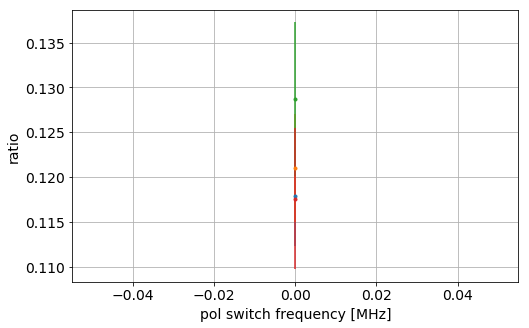

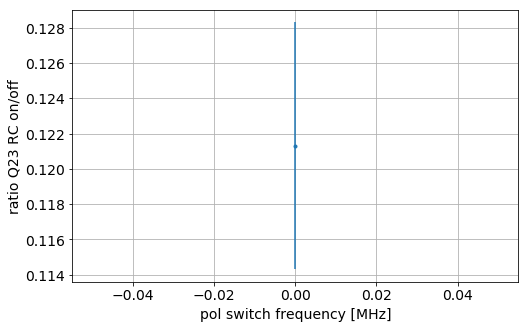

In [107]:
fig, ax = plt.subplots(figsize = (8,5))
for r, e in zip(ratio, err):
    ax.errorbar(frequencies/1e6, r, yerr = e, fmt = '.')

ax.set_xlabel('pol switch frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(frequencies/1e6, np.nanmean(ratio, axis=0), yerr = np.nanmean(err, axis=0), fmt = '.')

ax.set_xlabel('pol switch frequency [MHz]')
ax.set_ylabel('ratio Q23 RC on/off')

ax.grid(True)

set_fontsize(ax, 14)

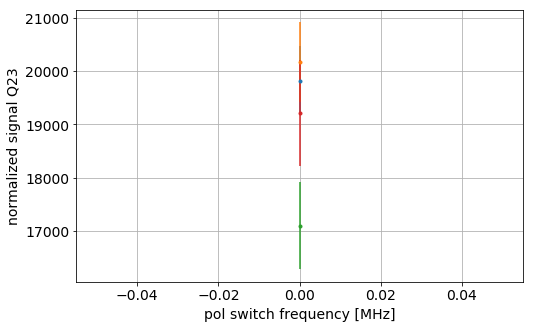

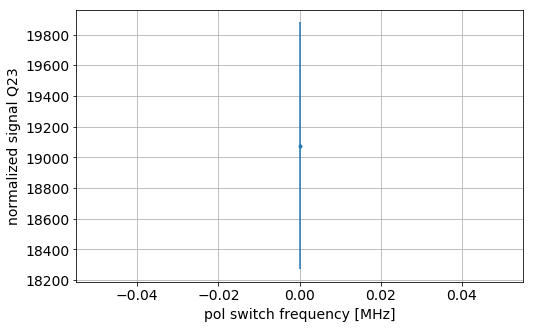

In [108]:
y = np.nanmean(o, axis = 1).reshape(-1,nreshape)
y[m] = np.nan
yerr = np.nanstd(o, axis = 1)/np.sqrt((~np.isnan(o)).sum(axis = 1))
yerr = yerr.reshape(-1,nreshape)
yerr[m] = np.nan

fig, ax = plt.subplots(figsize = (8,5))

for oi, oei in zip(y, yerr):
    ax.errorbar(frequencies/1e6, oi, yerr = oei, fmt = '.')
    

ax.set_xlabel('pol switch frequency [MHz]')
ax.set_ylabel('normalized signal Q23')

ax.grid(True)
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))

ax.errorbar(frequencies/1e6, np.nanmean(y, axis = 0), yerr = np.nanmean(yerr, axis = 0), fmt = '.')
    

ax.set_xlabel('pol switch frequency [MHz]')
ax.set_ylabel('normalized signal Q23')

ax.grid(True)
set_fontsize(ax, 14)

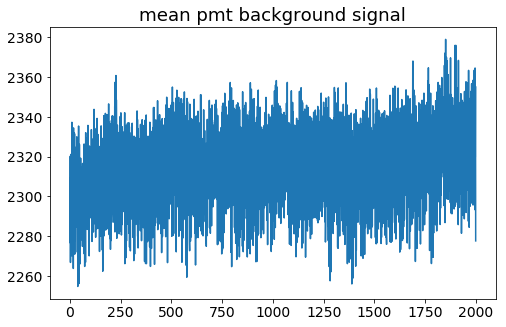

In [109]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pmt_data[:,-500:].mean(axis = 1))
ax.set_title('mean pmt background signal')
set_fontsize(ax, 14)

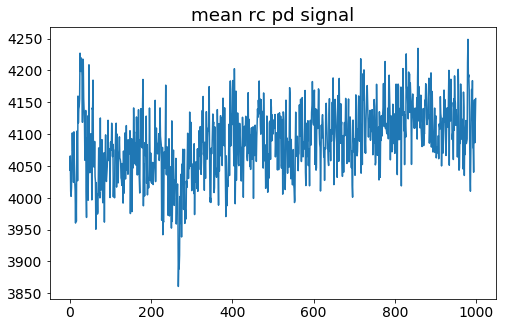

In [110]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdrc_data.mean(axis = 1)[mask_sh_open])
ax.set_title('mean rc pd signal')
set_fontsize(ax, 14)

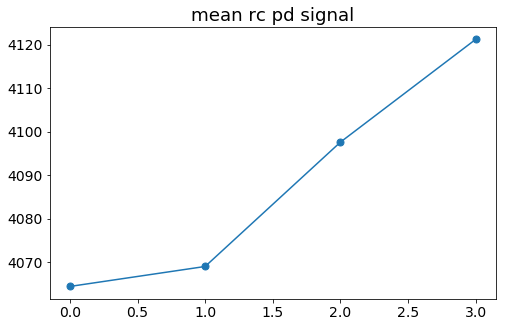

In [111]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdrc_data.mean(axis = 1)[mask_sh_open].reshape(-1, ngroup//2).mean(axis = 1), '.-', ms = 14)
ax.set_title('mean rc pd signal')
set_fontsize(ax, 14)

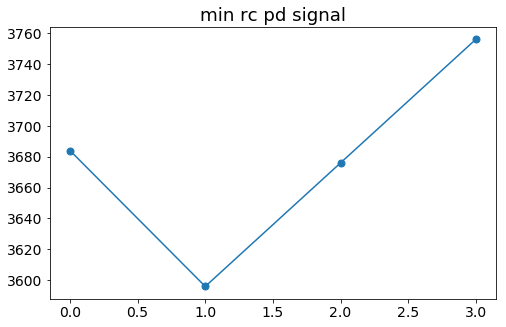

In [112]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdrc_data.min(axis = 1)[mask_sh_open].reshape(-1, ngroup//2).min(axis = 1), '.-', ms = 14)
ax.set_title('min rc pd signal')
set_fontsize(ax, 14)

## Scan Microwave polarization switching frequency Q23 DET
80 mW UV power

In [116]:
slice_flm  = np.s_[-500:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [117]:
dnames = [dset_names[7]]
devices = ()

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
                     
for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

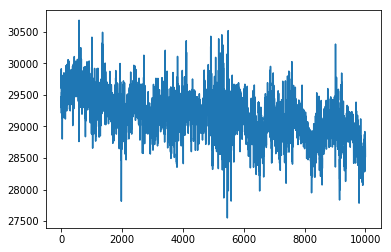

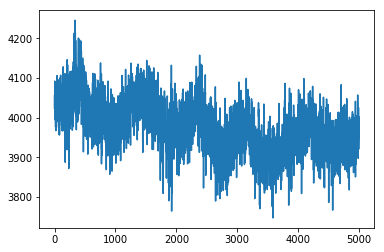

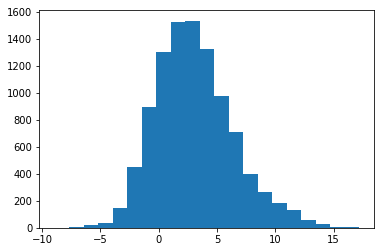

In [118]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_), bins = 21);

In [119]:
yag_cutoff = 250
ptn_cutoff = 12000
abs_cutoff = 3
fl_cutoff = -5000

In [120]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

53.1% data discarded


In [121]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

n = fluorescence_integral/absorption_integral

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

In [122]:
ngroup = 500
nreshape = 5

In [123]:
o = fluorescence_integral[mask_sh_open].reshape(-1,ngroup//2)/\
    absorption_integral[mask_sh_open].reshape(-1,ngroup//2)
c = fluorescence_integral[mask_sh_closed].reshape(-1, ngroup//2)/\
    absorption_integral[mask_sh_closed].reshape(-1, ngroup//2)

In [124]:
ratio, err = ratio_with_error(np.nanmean(o, axis = 1), np.nanmean(c, axis = 1), 
                              np.nanstd(o, axis = 1)/np.sqrt(np.sum(~np.isnan(o), axis = 1)),
                              np.nanstd(c, axis = 1)/np.sqrt(np.sum(~np.isnan(c), axis = 1))
                             )

In [125]:
ratio = ratio.reshape(-1,nreshape)
err = err.reshape(-1,nreshape)

In [126]:
frequencies = np.array([0.5, 1, 1.25, 1.5, 2])*1e6

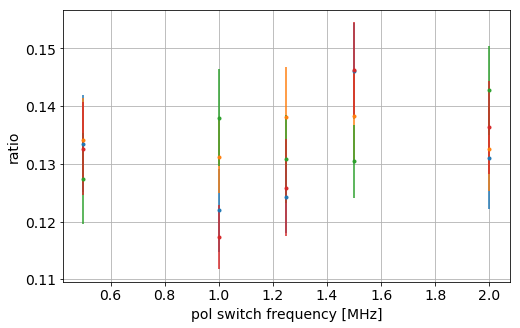

In [127]:
fig, ax = plt.subplots(figsize = (8,5))
for r, e in zip(ratio, err):
    ax.errorbar(frequencies/1e6, r, yerr = e, fmt = '.')

ax.set_xlabel('pol switch frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [128]:
# remove points where the RC laser was acting up
m = (pdrc_data.min(axis = 1)[mask_sh_open].reshape(-1, ngroup//2).min(axis = 1)) < 1000
m = m.reshape(-1,nreshape)
ratio[m] = np.nan
err[m] = np.nan

# remove points far outside the mean
std_factor = 4
rmean = np.nanmedian(ratio, axis = 0)
rstd = np.nanmedian(err, axis = 0)

m = ~((ratio >= rmean - std_factor*rstd) & (ratio <= rmean + std_factor*rstd))
ratio[m] = np.nan
err[m] = np.nan

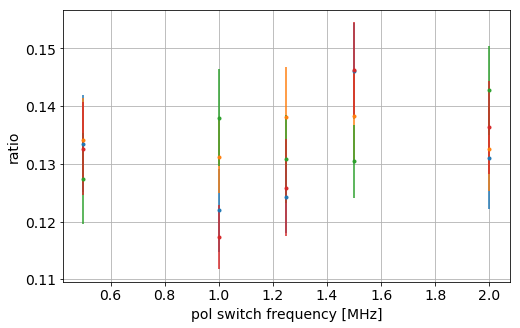

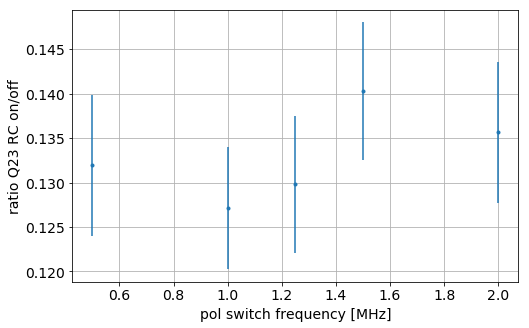

In [129]:
fig, ax = plt.subplots(figsize = (8,5))
for r, e in zip(ratio, err):
    ax.errorbar(frequencies/1e6, r, yerr = e, fmt = '.')

ax.set_xlabel('pol switch frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(frequencies/1e6, np.nanmean(ratio, axis=0), yerr = np.nanmean(err, axis=0), fmt = '.')

ax.set_xlabel('pol switch frequency [MHz]')
ax.set_ylabel('ratio Q23 RC on/off')

ax.grid(True)

set_fontsize(ax, 14)

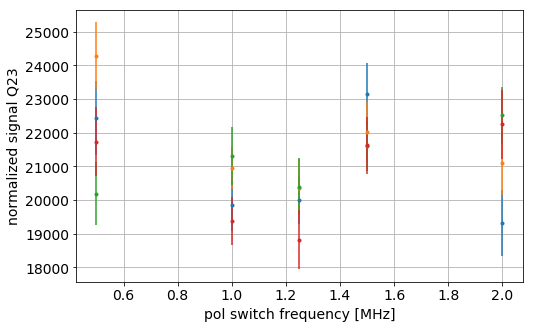

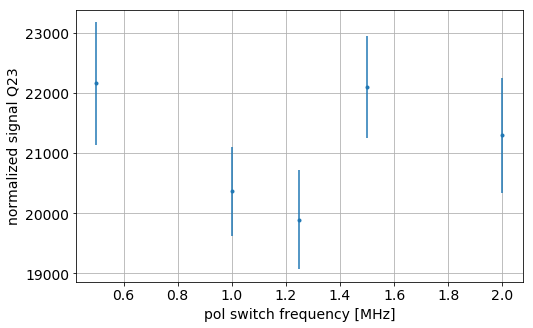

In [130]:
y = np.nanmean(o, axis = 1).reshape(-1,nreshape)
y[m] = np.nan
yerr = np.nanstd(o, axis = 1)/np.sqrt((~np.isnan(o)).sum(axis = 1))
yerr = yerr.reshape(-1,nreshape)
yerr[m] = np.nan

fig, ax = plt.subplots(figsize = (8,5))

for oi, oei in zip(y, yerr):
    ax.errorbar(frequencies/1e6, oi, yerr = oei, fmt = '.')
    

ax.set_xlabel('pol switch frequency [MHz]')
ax.set_ylabel('normalized signal Q23')

ax.grid(True)
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))

ax.errorbar(frequencies/1e6, np.nanmean(y, axis = 0), yerr = np.nanmean(yerr, axis = 0), fmt = '.')
    

ax.set_xlabel('pol switch frequency [MHz]')
ax.set_ylabel('normalized signal Q23')

ax.grid(True)
set_fontsize(ax, 14)

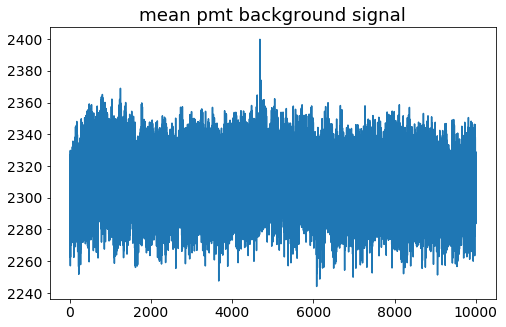

In [131]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pmt_data[:,-500:].mean(axis = 1))
ax.set_title('mean pmt background signal')
set_fontsize(ax, 14)

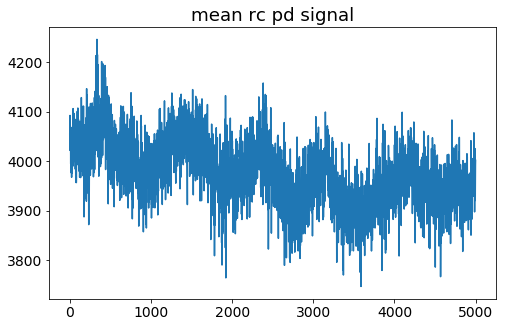

In [132]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdrc_data.mean(axis = 1)[mask_sh_open])
ax.set_title('mean rc pd signal')
set_fontsize(ax, 14)

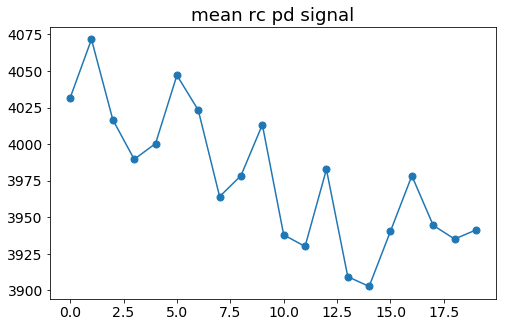

In [133]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdrc_data.mean(axis = 1)[mask_sh_open].reshape(-1, ngroup//2).mean(axis = 1), '.-', ms = 14)
ax.set_title('mean rc pd signal')
set_fontsize(ax, 14)

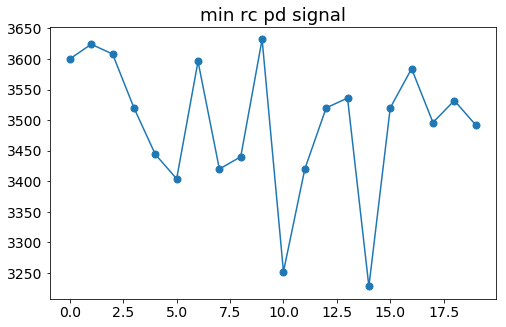

In [134]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdrc_data.min(axis = 1)[mask_sh_open].reshape(-1, ngroup//2).min(axis = 1), '.-', ms = 14)
ax.set_title('min rc pd signal')
set_fontsize(ax, 14)

## Scan J12 microwave power Q23 DET
79 mW UV power

In [290]:
slice_flm  = np.s_[-500:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [291]:
dnames = [dset_names[8]]
devices = ()

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
                     
for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

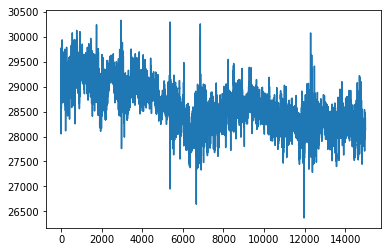

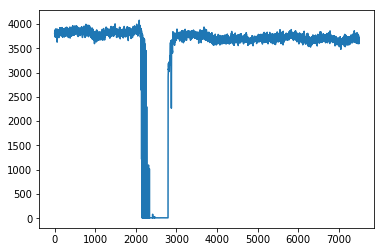

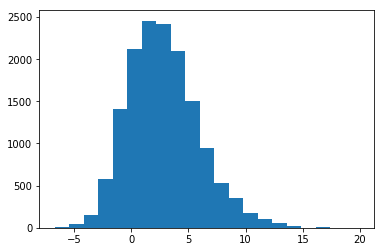

In [292]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_), bins = 21);

In [293]:
yag_cutoff = 250
ptn_cutoff = 12000
abs_cutoff = 3
fl_cutoff = -5000

In [294]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

56.8% data discarded


In [295]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

n = fluorescence_integral/absorption_integral

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

In [296]:
powers = np.arange(-20,-8,2)
ngroup = 500
nreshape = len(powers)

In [297]:
o = fluorescence_integral[mask_sh_open].reshape(-1,ngroup//2)/\
    absorption_integral[mask_sh_open].reshape(-1,ngroup//2)
c = fluorescence_integral[mask_sh_closed].reshape(-1, ngroup//2)/\
    absorption_integral[mask_sh_closed].reshape(-1, ngroup//2)

In [298]:
ratio, err = ratio_with_error(np.nanmean(o, axis = 1), np.nanmean(c, axis = 1), 
                              np.nanstd(o, axis = 1)/np.sqrt(np.sum(~np.isnan(o), axis = 1)),
                              np.nanstd(c, axis = 1)/np.sqrt(np.sum(~np.isnan(c), axis = 1))
                             )

In [299]:
ratio = ratio.reshape(-1,nreshape)
err = err.reshape(-1,nreshape)

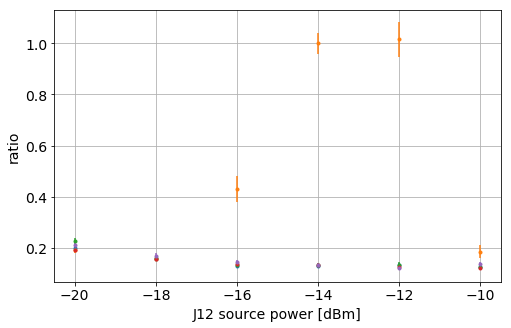

In [300]:
fig, ax = plt.subplots(figsize = (8,5))
for r, e in zip(ratio, err):
    ax.errorbar(powers, r, yerr = e, fmt = '.')

ax.set_xlabel('J12 source power [dBm]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [301]:
# remove points where the RC laser was acting up
m = (pdrc_data.min(axis = 1)[mask_sh_open].reshape(-1, ngroup//2).min(axis = 1)) < 1000
m = m.reshape(-1,nreshape)
ratio[m] = np.nan
err[m] = np.nan

# remove points far outside the mean
std_factor = 4
rmean = np.nanmedian(ratio, axis = 0)
rstd = np.nanmedian(err, axis = 0)

m = ~((ratio >= rmean - std_factor*rstd) & (ratio <= rmean + std_factor*rstd))
ratio[m] = np.nan
err[m] = np.nan

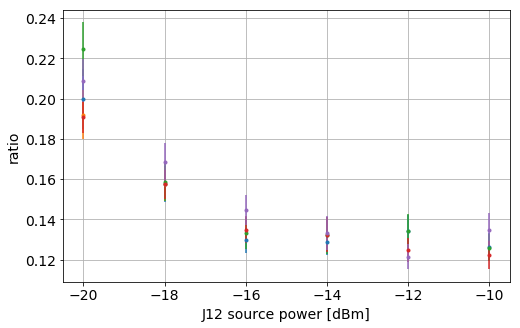

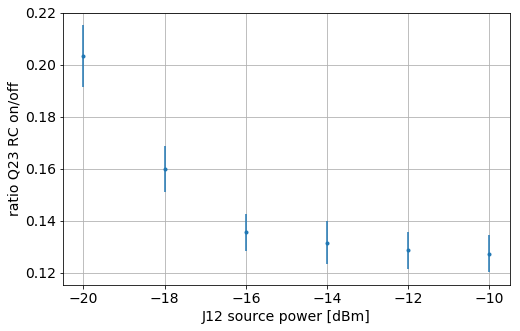

In [302]:
fig, ax = plt.subplots(figsize = (8,5))
for r, e in zip(ratio, err):
    ax.errorbar(powers, r, yerr = e, fmt = '.')

ax.set_xlabel('J12 source power [dBm]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(powers, np.nanmean(ratio, axis=0), yerr = np.nanmean(err, axis=0), fmt = '.')

ax.set_xlabel('J12 source power [dBm]')
ax.set_ylabel('ratio Q23 RC on/off')

ax.grid(True)

set_fontsize(ax, 14)

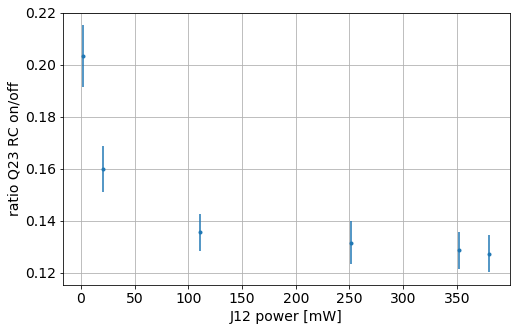

In [303]:
conv_to_power_J12 = dict([(-10, -7.2+30+3), (-12, -7.53+30+3), (-14, -9+30+3), 
                         (-16, -12.55+30+3), (-18, -19.96+30+3), (-20,-29.15+30+3)])
conv_dBm_to_mW = lambda p: 10**(p/10)

p = [conv_dBm_to_mW(conv_to_power_J12[val]) for val in powers]
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(p, np.nanmean(ratio, axis=0), yerr = np.nanmean(err, axis=0), fmt = '.')

ax.set_xlabel('J12 power [mW]')
ax.set_ylabel('ratio Q23 RC on/off')

ax.grid(True)

set_fontsize(ax, 14)

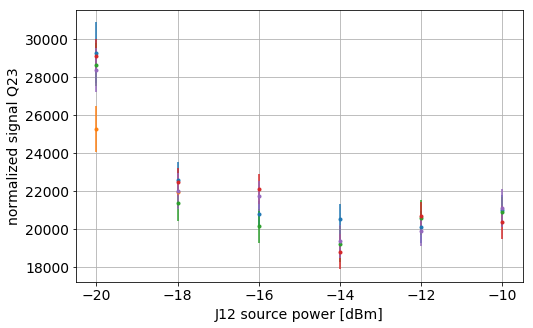

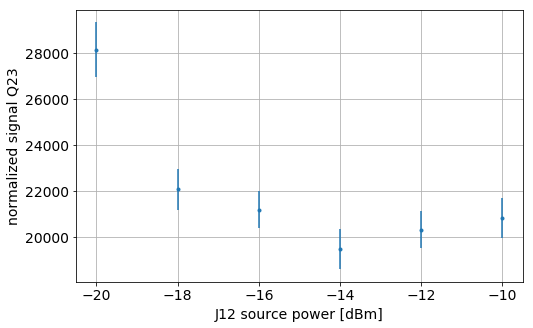

In [304]:
y = np.nanmean(o, axis = 1).reshape(-1,nreshape)
y[m] = np.nan
yerr = np.nanstd(o, axis = 1)/np.sqrt((~np.isnan(o)).sum(axis = 1))
yerr = yerr.reshape(-1,nreshape)
yerr[m] = np.nan

fig, ax = plt.subplots(figsize = (8,5))

for oi, oei in zip(y, yerr):
    ax.errorbar(powers, oi, yerr = oei, fmt = '.')
    

ax.set_xlabel('J12 source power [dBm]')
ax.set_ylabel('normalized signal Q23')

ax.grid(True)
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))

ax.errorbar(powers, np.nanmean(y, axis = 0), yerr = np.nanmean(yerr, axis = 0), fmt = '.')
    

ax.set_xlabel('J12 source power [dBm]')
ax.set_ylabel('normalized signal Q23')

ax.grid(True)
set_fontsize(ax, 14)

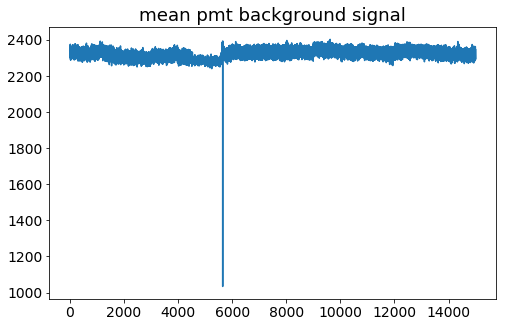

In [305]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pmt_data[:,-500:].mean(axis = 1))
ax.set_title('mean pmt background signal')
set_fontsize(ax, 14)

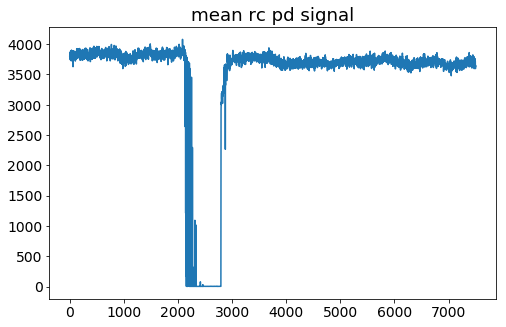

In [306]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdrc_data.mean(axis = 1)[mask_sh_open])
ax.set_title('mean rc pd signal')
set_fontsize(ax, 14)

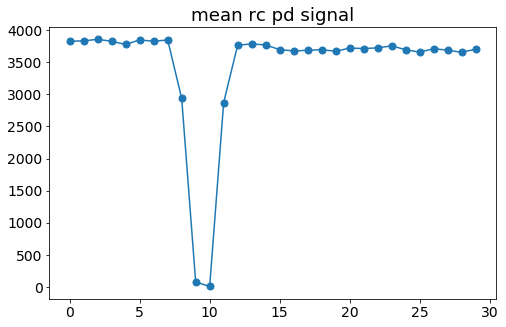

In [307]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdrc_data.mean(axis = 1)[mask_sh_open].reshape(-1, ngroup//2).mean(axis = 1), '.-', ms = 14)
ax.set_title('mean rc pd signal')
set_fontsize(ax, 14)

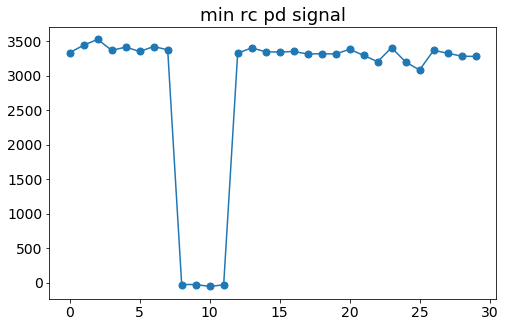

In [308]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdrc_data.min(axis = 1)[mask_sh_open].reshape(-1, ngroup//2).min(axis = 1), '.-', ms = 14)
ax.set_title('min rc pd signal')
set_fontsize(ax, 14)

## Scan J23 microwave power Q23 DET
79 mW UV power

J12 power set to -12 dBm source, $\approx 350$ mW

In [309]:
slice_flm  = np.s_[-500:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [310]:
dnames = [dset_names[9]]
devices = ()

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
                     
for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

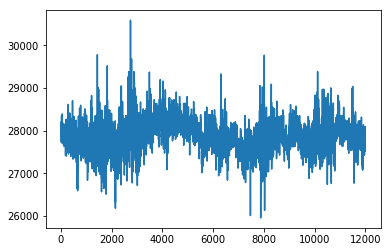

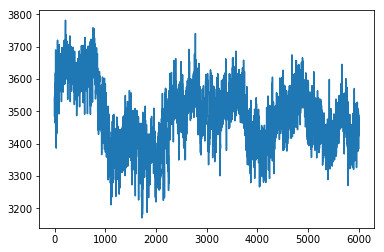

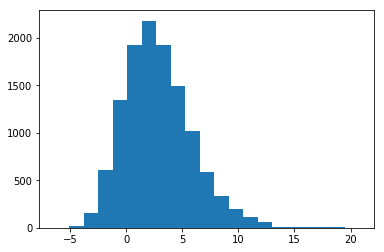

In [311]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_), bins = 21);

In [312]:
yag_cutoff = 250
ptn_cutoff = 12000
abs_cutoff = 3
fl_cutoff = -5000

In [313]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

56.5% data discarded


In [314]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

n = fluorescence_integral/absorption_integral

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

In [315]:
powers = np.array([-13.9, -11.71, -10.57, -9.82, -9.55, -9.35])
ngroup = 500
nreshape = len(powers)

In [316]:
o = fluorescence_integral[mask_sh_open].reshape(-1,ngroup//2)/\
    absorption_integral[mask_sh_open].reshape(-1,ngroup//2)
c = fluorescence_integral[mask_sh_closed].reshape(-1, ngroup//2)/\
    absorption_integral[mask_sh_closed].reshape(-1, ngroup//2)

In [317]:
ratio, err = ratio_with_error(np.nanmean(o, axis = 1), np.nanmean(c, axis = 1), 
                              np.nanstd(o, axis = 1)/np.sqrt(np.sum(~np.isnan(o), axis = 1)),
                              np.nanstd(c, axis = 1)/np.sqrt(np.sum(~np.isnan(c), axis = 1))
                             )

In [318]:
ratio = ratio.reshape(-1,nreshape)
err = err.reshape(-1,nreshape)

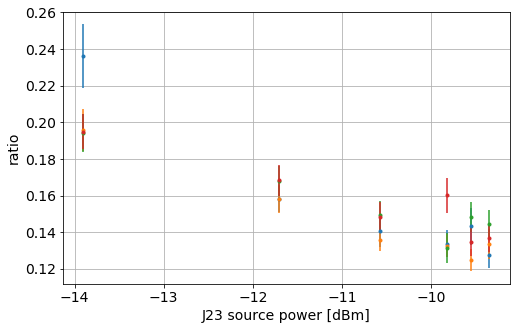

In [319]:
fig, ax = plt.subplots(figsize = (8,5))
for r, e in zip(ratio, err):
    ax.errorbar(powers, r, yerr = e, fmt = '.')

ax.set_xlabel('J23 source power [dBm]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [320]:
# remove points where the RC laser was acting up
m = (pdrc_data.min(axis = 1)[mask_sh_open].reshape(-1, ngroup//2).min(axis = 1)) < 1000
m = m.reshape(-1,nreshape)
ratio[m] = np.nan
err[m] = np.nan

# remove points far outside the mean
std_factor = 4
rmean = np.nanmedian(ratio, axis = 0)
rstd = np.nanmedian(err, axis = 0)

m = ~((ratio >= rmean - std_factor*rstd) & (ratio <= rmean + std_factor*rstd))
ratio[m] = np.nan
err[m] = np.nan

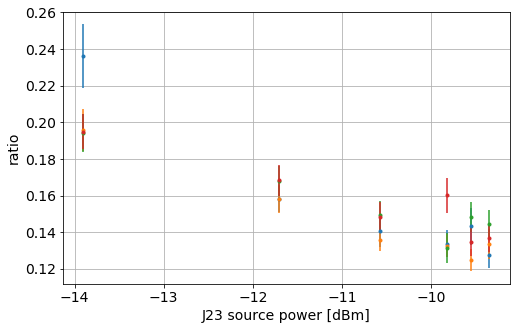

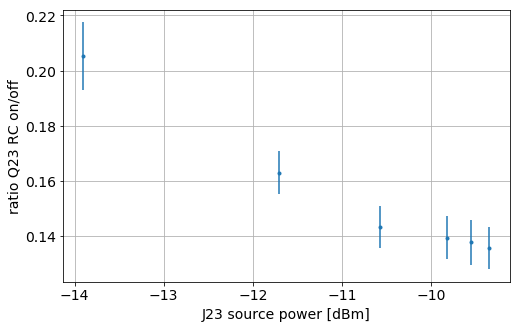

In [321]:
fig, ax = plt.subplots(figsize = (8,5))
for r, e in zip(ratio, err):
    ax.errorbar(powers, r, yerr = e, fmt = '.')

ax.set_xlabel('J23 source power [dBm]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(powers, np.nanmean(ratio, axis=0), yerr = np.nanmean(err, axis=0), fmt = '.')

ax.set_xlabel('J23 source power [dBm]')
ax.set_ylabel('ratio Q23 RC on/off')

ax.grid(True)

set_fontsize(ax, 14)

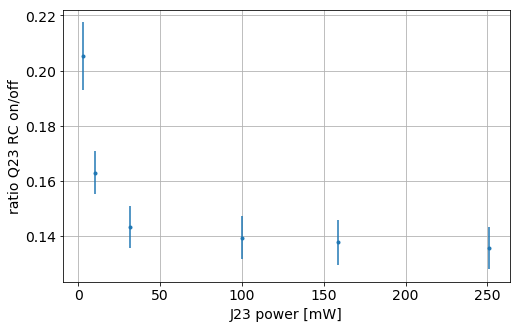

In [322]:
conv_to_power_J23 = dict([(-13.9, 5), (-11.71, 10), (-10.57, 15), (-9.82, 20),
                          (-9.55, 22), (-9.35, 24)])
conv_dBm_to_mW = lambda p: 10**(p/10)

p = [conv_dBm_to_mW(conv_to_power_J23[val]) for val in powers]
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(p, np.nanmean(ratio, axis=0), yerr = np.nanmean(err, axis=0), fmt = '.')

ax.set_xlabel('J23 power [mW]')
ax.set_ylabel('ratio Q23 RC on/off')

ax.grid(True)

set_fontsize(ax, 14)

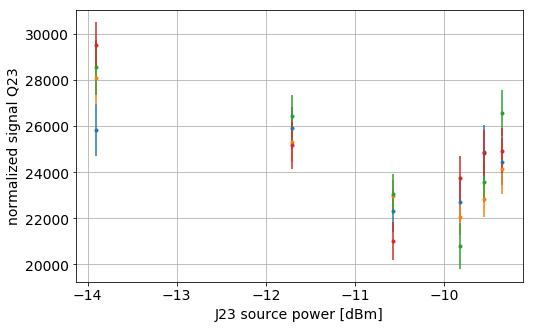

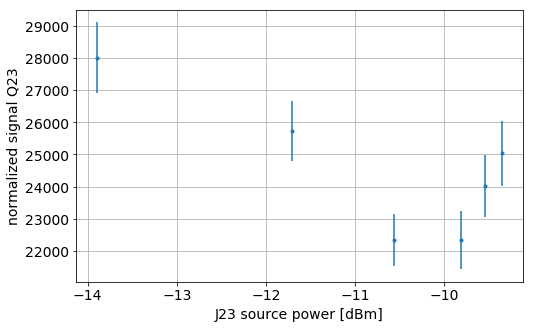

In [210]:
y = np.nanmean(o, axis = 1).reshape(-1,nreshape)
y[m] = np.nan
yerr = np.nanstd(o, axis = 1)/np.sqrt((~np.isnan(o)).sum(axis = 1))
yerr = yerr.reshape(-1,nreshape)
yerr[m] = np.nan

fig, ax = plt.subplots(figsize = (8,5))

for oi, oei in zip(y, yerr):
    ax.errorbar(powers, oi, yerr = oei, fmt = '.')
    

ax.set_xlabel('J23 source power [dBm]')
ax.set_ylabel('normalized signal Q23')

ax.grid(True)
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))

ax.errorbar(powers, np.nanmean(y, axis = 0), yerr = np.nanmean(yerr, axis = 0), fmt = '.')
    

ax.set_xlabel('J23 source power [dBm]')
ax.set_ylabel('normalized signal Q23')

ax.grid(True)
set_fontsize(ax, 14)

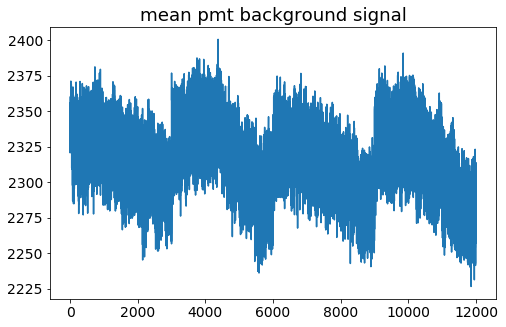

In [211]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pmt_data[:,-500:].mean(axis = 1))
ax.set_title('mean pmt background signal')
set_fontsize(ax, 14)

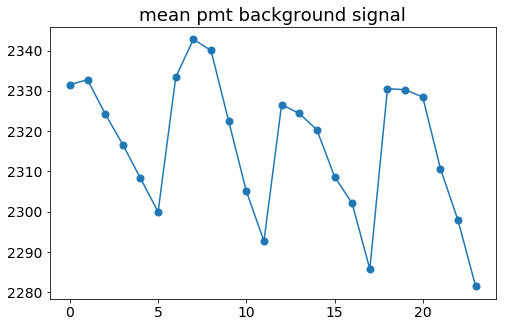

In [212]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pmt_data[:,-500:].mean(axis = 1).reshape(-1, ngroup).mean(axis = 1), '.-', ms = 14)
ax.set_title('mean pmt background signal')
set_fontsize(ax, 14)

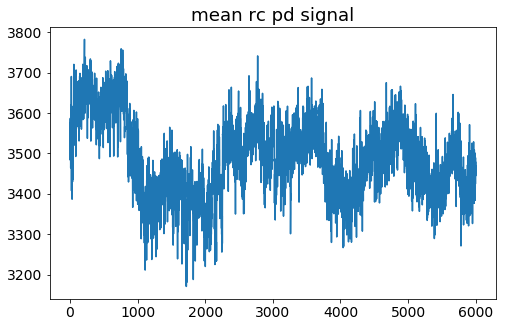

In [213]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdrc_data.mean(axis = 1)[mask_sh_open])
ax.set_title('mean rc pd signal')
set_fontsize(ax, 14)

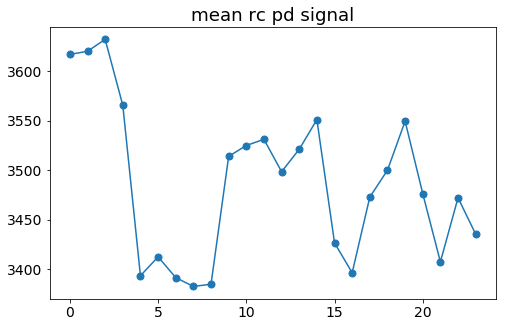

In [214]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdrc_data.mean(axis = 1)[mask_sh_open].reshape(-1, ngroup//2).mean(axis = 1), '.-', ms = 14)
ax.set_title('mean rc pd signal')
set_fontsize(ax, 14)

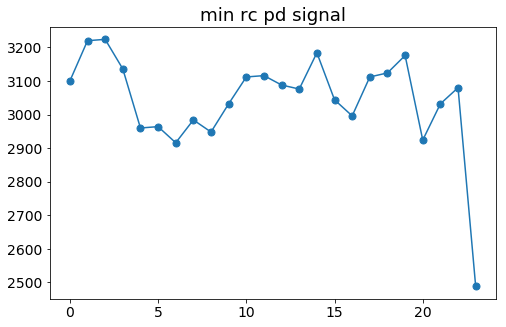

In [215]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdrc_data.min(axis = 1)[mask_sh_open].reshape(-1, ngroup//2).min(axis = 1), '.-', ms = 14)
ax.set_title('min rc pd signal')
set_fontsize(ax, 14)